In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
train=pd.read_csv('C:/Users/sravyaburugu/Desktop/IDMP/train.csv')

In [3]:
train.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [4]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [5]:
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")
df = train[['date', 'sales']]

In [6]:
train.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [7]:
df=df.set_index(df.date)
df.drop('date',axis=1,inplace=True)

In [8]:
df.tail()

,sales
date,
2017-08-15,438.133
2017-08-15,154.553
2017-08-15,2419.729
2017-08-15,121.000
2017-08-15,16.000


In [9]:
#resample it to monthly basis to make analysis easier
df = df.resample('M').mean()

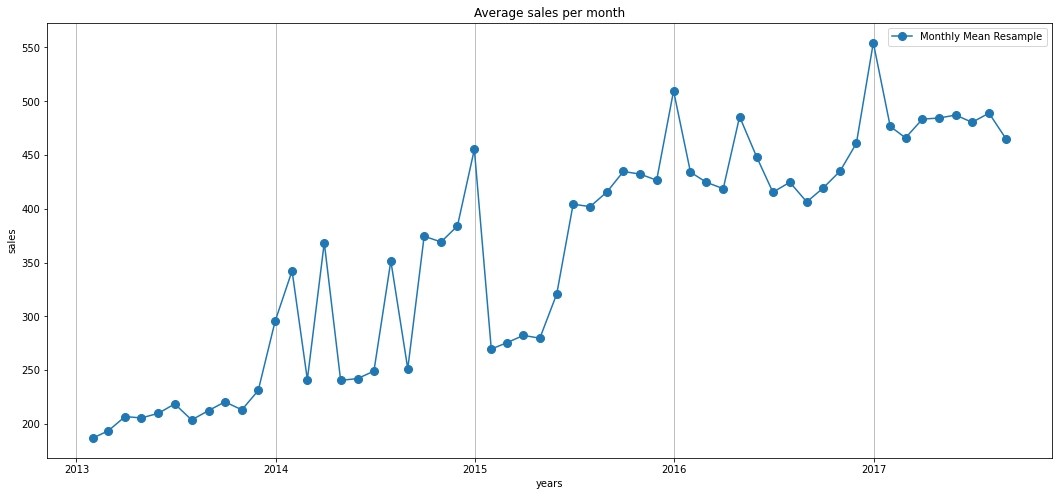

In [10]:
y = df['sales']
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y,marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('sales')
ax.set_title('Average sales per month')
ax.set_xlabel('years')
ax.grid(axis='x')
ax.legend();

Increasing Trend in Average Sales

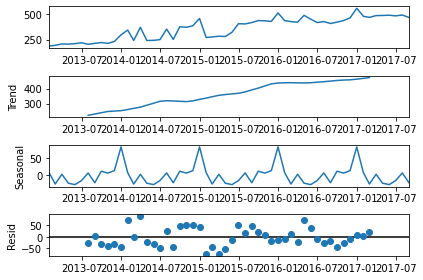

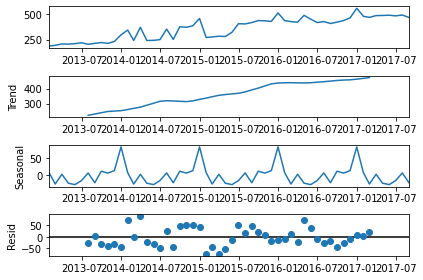

In [11]:
df_decomposed = seasonal_decompose(df,model='additive')
df_decomposed.plot()

Seasonality is also absorved throughout in addition to increasing trend

### Stationarity Check : Augmented Dickey-Fuller test (ADF test)

H0 : 'The time series is not stationary' \
H1 : 'The time series is stationary'

In [12]:
dftest = adfuller(df.dropna(), autolag='AIC')

In [13]:
print("test statistic:",dftest[0],"\n P-value:" ,dftest[1],"\nCritiical Values",dftest[4])

test statistic: -1.5746639319400968 
 P-value: 0.49630690894556684 
Critiical Values {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


With 99%, 95% and 90% data is not stationary, so need to make it stationary

Visualizing Stationarity

In [14]:
sales_mean = df.sales.rolling(window=12).mean()
sales_std = df.sales.rolling(window=12).std()

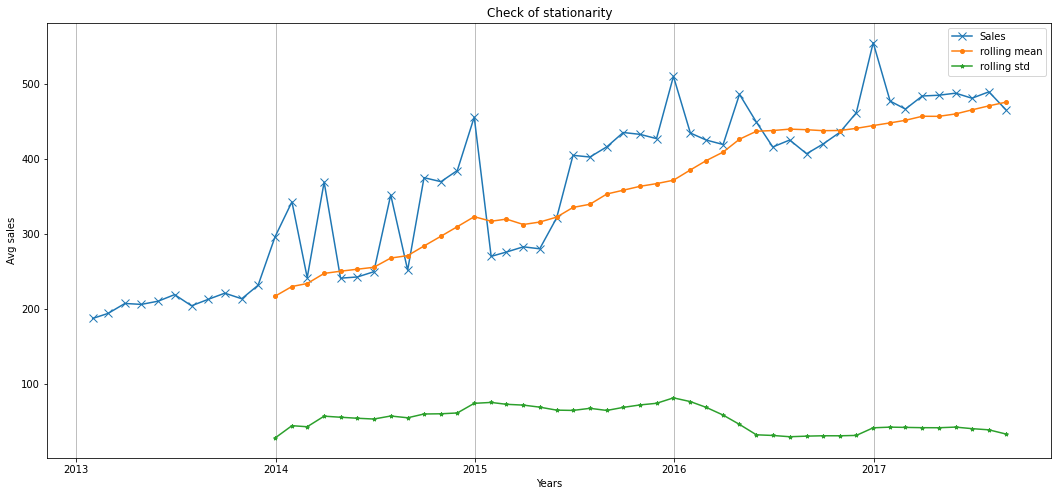

In [15]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df.sales,marker='x', markersize=8, label='Sales')
ax.plot(sales_mean,marker='o', markersize=4, label='rolling mean');
ax.plot(sales_std,marker='*', markersize=4, label='rolling std');
ax.legend()
plt.xlabel('Years')
plt.ylabel('Avg sales')
plt.title('Check of stationarity')
ax.grid(axis='x')

Hypothesis testing coincides with visualization, the data is not stationary although SD seems a bit constant

Inducing Lag to make data stationary

In [16]:
df_lag = df.sales - df.sales.shift(12) #monthly lag

In [17]:
df_lag.tail(10)

date
2016-11-30    34.374987
2016-12-31    44.824278
2017-01-31    42.546523
2017-02-28    41.276070
2017-03-31    64.665233
2017-04-30    -1.266678
2017-05-31    38.601336
2017-06-30    64.975749
2017-07-31    64.241069
2017-08-31    58.707501
Freq: M, Name: sales, dtype: float64

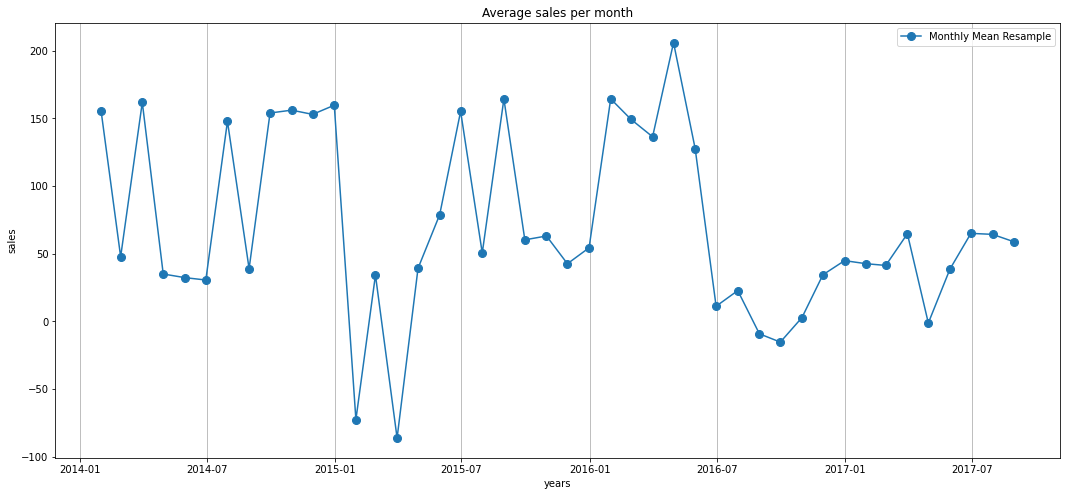

In [18]:
y = df_lag
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y,marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('sales')
ax.set_title('Average sales per month')
ax.set_xlabel('years')
ax.grid(axis='x')
ax.legend()

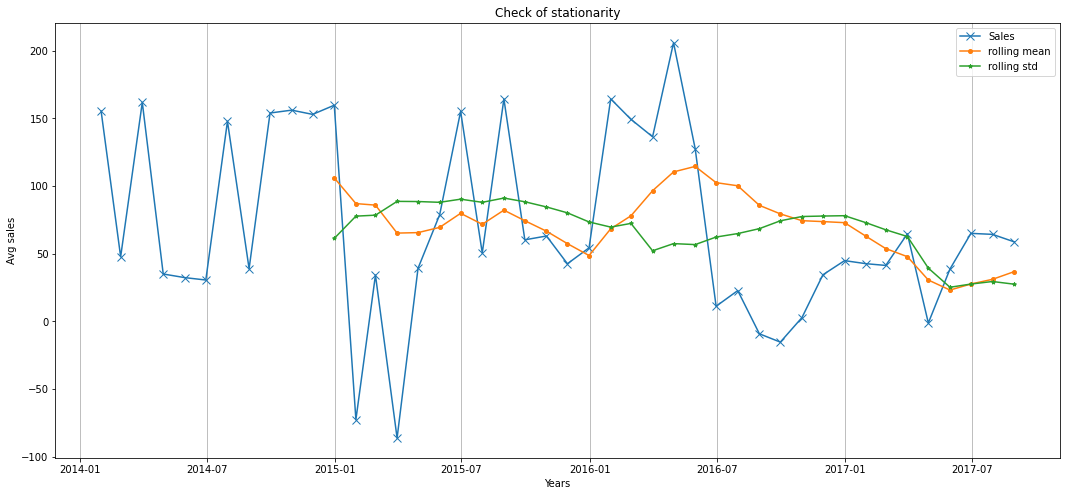

In [19]:
sales_mean = df_lag.rolling(window=12).mean()
sales_std = df_lag.rolling(window=12).std()
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y,marker='x', markersize=8, label='Sales')
ax.plot(sales_mean,marker='o', markersize=4, label='rolling mean');
ax.plot(sales_std,marker='*', markersize=4, label='rolling std');
ax.legend()
plt.xlabel('Years')
plt.ylabel('Avg sales')
plt.title('Check of stationarity')
ax.grid(axis='x')

In [20]:
dftest = adfuller(df_lag.dropna(), autolag='AIC')

In [21]:
print("test statistic:",dftest[0],"\n P-value:" ,dftest[1],"\nCritiical Values",dftest[4])

test statistic: -3.753151224189836 
 P-value: 0.003424701220205552 
Critiical Values {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}


With 99%,95%,90% confidence the data is stationary

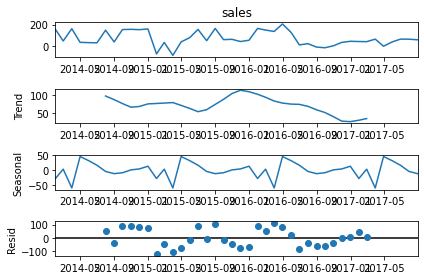

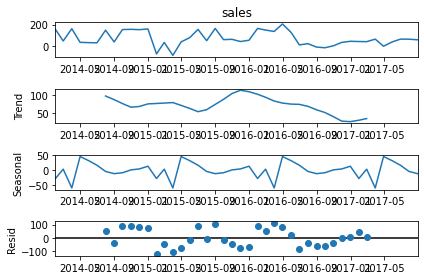

In [22]:
df_decomposed = seasonal_decompose(df_lag.dropna(),model='additive')
df_decomposed.plot()

## Exponential Smoothing

Since the data has trend and seasonality we can use this model

In [23]:
df_train = df.iloc[:-12]

In [24]:
df_train

,sales
date,
2013-01-31,186.952405
2013-02-28,193.581846
2013-03-31,206.880581
2013-04-30,205.639071
2013-05-31,209.943594
2013-06-30,218.655893
2013-07-31,203.783364
2013-08-31,212.479434
2013-09-30,220.593588


In [25]:
df_test = df.iloc[-12:]

In [26]:
df_test

,sales
date,
2016-09-30,419.331240
2016-10-31,435.002169
2016-11-30,460.954736
2016-12-31,554.438600
2017-01-31,476.596791
2017-02-28,465.971468
2017-03-31,483.400632
2017-04-30,484.386616
2017-05-31,487.162797


In [27]:
es = ExponentialSmoothing(df_train, seasonal_periods=12,trend='add', seasonal='mul').fit()

In [28]:
es_preds = es.forecast(steps=12)

In [29]:
pd.DataFrame(es_preds)

,0
2016-09-30,520.814747
2016-10-31,511.555453
2016-11-30,519.243530
2016-12-31,622.052201
2017-01-31,500.856417
2017-02-28,465.774988
2017-03-31,509.183294
2017-04-30,497.300841
2017-05-31,493.107696
2017-06-30,509.375725


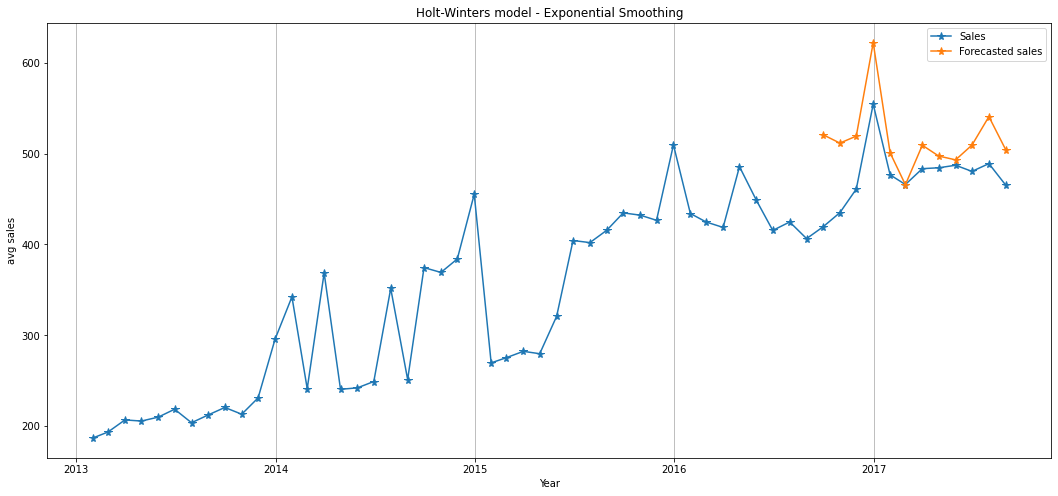

In [30]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df,marker='*', markersize=8, label='Sales')
ax.plot(es_preds,marker='*', markersize=8, label='Forecasted sales');
plt.xlabel('Year')
plt.ylabel('avg sales')
plt.title('Holt-Winters model - Exponential Smoothing' )
ax.grid(axis='x')
ax.legend()
plt.show()

In [31]:
residuals = np.abs(es_preds[0] - df_test['sales'])

In [32]:
mape = (residuals/df_test['sales']).mean()*100

In [33]:
print(f'The mape value of Holt-Winters model is {mape}')

The mape value of Holt-Winters model is 11.090501837424162


In [34]:
es_preds=es.forecast(steps=24)

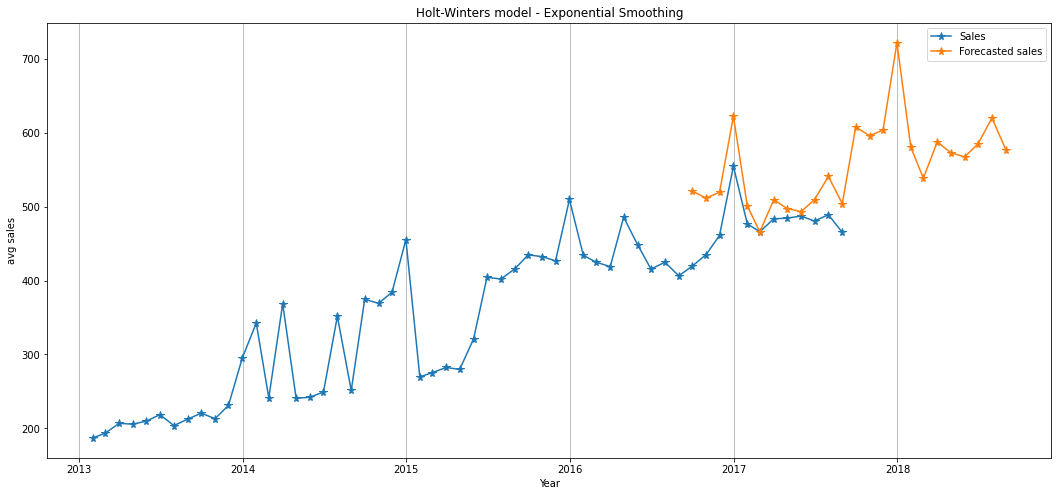

In [35]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df,marker='*', markersize=8, label='Sales')
ax.plot(es_preds,marker='*', markersize=8, label='Forecasted sales');
plt.xlabel('Year')
plt.ylabel('avg sales')
plt.title('Holt-Winters model - Exponential Smoothing' )
ax.grid(axis='x')
ax.legend()
plt.show()